In [1]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pydicom
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.initializers import Constant
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.python.ops import array_ops
from tqdm import tqdm
from keras import backend as K
import tensorflow as tf
import keras
from keras.applications import Xception
from keras.models import Model, load_model
from math import ceil, floor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import log_loss
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

In [2]:
METRICS = [tf.keras.metrics.BinaryAccuracy(), 
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.AUC(),
           tf.keras.metrics.SpecificityAtSensitivity(0.5),
           tf.keras.metrics.SensitivityAtSpecificity(0.5)
          ]

In [3]:
def plot_learning_curves(history, metrics_to_plot = ['loss','binary_accuracy', 'precision', 'recall', 'auc']):
  ncols = 2
  nrows = math.ceil(len(metrics_to_plot) / 2)
  if len(metrics_to_plot) <= 2:
        fig, axes = plt.subplots(nrows,ncols, figsize=(20,10))
        for i in range(2):
            axes[i].plot(history.history[metrics_to_plot[i]], label=metrics_to_plot[i] +' (training data)')
            axes[i].plot(history.history['val_'+metrics_to_plot[i]], label=metrics_to_plot[i] + ' (val data)')
            axes[i].set_ylabel('Value', fontsize = 20)
            axes[i].set_xlabel('No. epoch', fontsize = 20)
            axes[i].legend(prop={'size': 20})
            axes[i].set_title(metrics_to_plot[i], size = 22)
  else:        
      fig, axes = plt.subplots(nrows,ncols, figsize=(15,20))

      for i in range(ncols):
        for j in range(nrows):
          metric_idx = j * ncols + i
          if metric_idx >= len(metrics_to_plot):
                break
          axes[j,i].plot(history.history[metrics_to_plot[metric_idx]], label=metrics_to_plot[metric_idx] +' (training data)')
          axes[j,i].plot(history.history['val_'+metrics_to_plot[metric_idx]], label=metrics_to_plot[metric_idx] + ' (val data)')
          axes[j,i].set_ylabel('Value', fontsize = 20)
          axes[j,i].set_xlabel('No. epoch', fontsize = 20)
          axes[j,i].legend(prop={'size': 20})
          axes[j,i].set_title(metrics_to_plot[metric_idx], size = 22)
  plt.tight_layout()

In [4]:
def np_multilabel_loss(class_weights=None):
    def single_class_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        y_pred = tf.where(y_pred > 1-(1e-07), 1-1e-07, y_pred)
        y_pred = tf.where(y_pred < 1e-07, 1e-07, y_pred)
        single_class_cross_entropies = - tf.reduce_mean(y_true * tf.math.log(y_pred) + (1-y_true) * tf.math.log(1-y_pred), axis=0)

        if class_weights is None:
            loss = tf.reduce_mean(single_class_cross_entropies)
        else:
            loss = tf.reduce_sum(class_weights*single_class_cross_entropies)
        return loss
    return single_class_crossentropy


In [5]:
METRICS = METRICS + [np_multilabel_loss()]
METRICS_NAMES = []
for metric in METRICS:
    if hasattr(metric, 'name'):
        METRICS_NAMES.append(metric.name)
    else:
        METRICS_NAMES.append(metric.__name__)

In [6]:
os.listdir('/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection')

['stage_2_train',
 'stage_2_test',
 'stage_2_sample_submission.csv',
 'stage_2_train.csv']

In [7]:
BASE_PATH = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = 'stage_2_train/'
TEST_DIR = 'stage_2_test/'
train_df = pd.read_csv(BASE_PATH + 'stage_2_train.csv')

In [8]:
sub_df = pd.read_csv(BASE_PATH + 'stage_2_sample_submission.csv')

train_df['filename'] = train_df['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
train_df['type'] = train_df['ID'].apply(lambda st: st.split('_')[2])
sub_df['filename'] = sub_df['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
sub_df['type'] = sub_df['ID'].apply(lambda st: st.split('_')[2])

print(train_df.shape)
train_df.head()

(4516842, 4)


,ID,Label,filename,type
0,ID_12cadc6af_epidural,0,ID_12cadc6af.png,epidural
1,ID_12cadc6af_intraparenchymal,0,ID_12cadc6af.png,intraparenchymal
2,ID_12cadc6af_intraventricular,0,ID_12cadc6af.png,intraventricular
3,ID_12cadc6af_subarachnoid,0,ID_12cadc6af.png,subarachnoid
4,ID_12cadc6af_subdural,0,ID_12cadc6af.png,subdural


In [9]:
test_df = pd.DataFrame(sub_df.filename.unique(), columns=['filename'])
print(test_df.shape)
test_df.head()

(121232, 1)


,filename
0,ID_0fbf6a978.png
1,ID_d62ec3412.png
2,ID_cb544194b.png
3,ID_0d62513ec.png
4,ID_fc45b2151.png


In [10]:
subtypes = train_df.groupby('type').sum()
subtypes

,Label
type,
any,107933
epidural,3145
intraparenchymal,36118
intraventricular,26205
subarachnoid,35675
subdural,47166


<AxesSubplot:xlabel='Label', ylabel='type'>

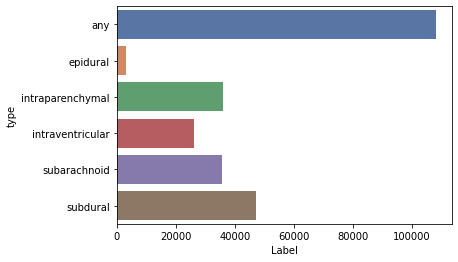

In [11]:
sns.barplot(y=subtypes.index, x=subtypes.Label, palette="deep")

In [12]:
np.random.seed(2023)
sample_files = np.random.choice(os.listdir(BASE_PATH + TRAIN_DIR), 150000) # take the rest for testing
sample_df = train_df[train_df.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(sample_files)]

In [13]:
pivot_df = sample_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
print(pivot_df.shape)
pivot_df

(135868, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf.png,0,0,0,0,0,0
1,ID_0000950d7.png,0,0,0,0,0,0
2,ID_0000ca2f6.png,0,0,0,0,0,0
3,ID_00019828f.png,0,0,0,0,0,0
4,ID_0002003a8.png,0,0,0,0,0,0
...,...,...,...,...,...,...,...
135863,ID_fffd82081.png,0,0,0,0,0,0
135864,ID_fffdc6bef.png,0,0,0,0,0,0
135865,ID_ffff59a97.png,0,0,0,0,0,0
135866,ID_ffff73ede.png,0,0,0,0,0,0


In [14]:
#one_df = pivot_df.drop(pivot_df.loc[pivot_df['subdural']==0].index)
#one_df

In [15]:
#zero_df = pivot_df.drop(pivot_df.loc[pivot_df['any']==1].index)
#zero_df

In [16]:
#zero_df = zero_df.sample(47166)
#zero_df

In [17]:
#sample_df = pd.concat([zero_df, one_df])
#sample_df

In [18]:
test_df = sub_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
print(test_df.shape)
test_df

(121232, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000000e27.png,0.5,0.5,0.5,0.5,0.5,0.5
1,ID_000009146.png,0.5,0.5,0.5,0.5,0.5,0.5
2,ID_00007b8cb.png,0.5,0.5,0.5,0.5,0.5,0.5
3,ID_000134952.png,0.5,0.5,0.5,0.5,0.5,0.5
4,ID_000176f2a.png,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
121227,ID_fffb40805.png,0.5,0.5,0.5,0.5,0.5,0.5
121228,ID_fffc74999.png,0.5,0.5,0.5,0.5,0.5,0.5
121229,ID_fffd3cc3b.png,0.5,0.5,0.5,0.5,0.5,0.5
121230,ID_fffdcca96.png,0.5,0.5,0.5,0.5,0.5,0.5


In [19]:
np.random.seed(2023)
sample_test = np.random.choice(os.listdir(BASE_PATH + TEST_DIR), 100000) 
test_sample_df = test_df[test_df.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(sample_test)]


In [20]:
test_sample_df

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000000e27.png,0.5,0.5,0.5,0.5,0.5,0.5
1,ID_000009146.png,0.5,0.5,0.5,0.5,0.5,0.5
2,ID_00007b8cb.png,0.5,0.5,0.5,0.5,0.5,0.5
3,ID_000134952.png,0.5,0.5,0.5,0.5,0.5,0.5
4,ID_000176f2a.png,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
121226,ID_fffaf0843.png,0.5,0.5,0.5,0.5,0.5,0.5
121228,ID_fffc74999.png,0.5,0.5,0.5,0.5,0.5,0.5
121229,ID_fffd3cc3b.png,0.5,0.5,0.5,0.5,0.5,0.5
121230,ID_fffdcca96.png,0.5,0.5,0.5,0.5,0.5,0.5


In [21]:
#zero_df = pivot_df.drop(pivot_df.loc[pivot_df['any']==1].index)
#zero_df

In [22]:
#zero_df = zero_df.sample(47166)

In [23]:
#sample_df = pd.concat([zero_df, one_df])
#sample_df

In [24]:
#from sklearn.utils import shuffle
#sample_df = shuffle(sample_df)

In [25]:
validation_df = pivot_df.sample(int(len(pivot_df) * 0.08))  
validation_df 

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
77117,ID_90f9df4f7.png,0,0,0,0,0,0
128619,ID_f261e9e29.png,1,0,0,0,1,0
3218,ID_061d7ef46.png,0,0,0,0,0,0
102453,ID_c0d7cef6f.png,0,0,0,0,0,0
79323,ID_953065001.png,0,0,0,0,0,0
...,...,...,...,...,...,...,...
26829,ID_3281c6608.png,0,0,0,0,0,0
65541,ID_7b3f231c0.png,0,0,0,0,0,0
103407,ID_c2a7e9e28.png,0,0,0,0,0,0
17641,ID_212e3914b.png,1,0,0,0,0,1


In [26]:
y_true = []
for i in range(len(validation_df)): 
    y_true.append(validation_df.iloc[i,1])
        


In [27]:
len(y_true)

10869

In [28]:
full_true = []
for i in range(len(validation_df)): 
    for j in range(1,7): 
        full_true.append(validation_df.iloc[i,j])
        


In [29]:
#len(full_true)

In [30]:
training_df = pivot_df[~(pivot_df.filename.isin(validation_df.filename))]
training_df


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf.png,0,0,0,0,0,0
1,ID_0000950d7.png,0,0,0,0,0,0
2,ID_0000ca2f6.png,0,0,0,0,0,0
3,ID_00019828f.png,0,0,0,0,0,0
4,ID_0002003a8.png,0,0,0,0,0,0
...,...,...,...,...,...,...,...
135862,ID_fffd0ca94.png,0,0,0,0,0,0
135863,ID_fffd82081.png,0,0,0,0,0,0
135865,ID_ffff59a97.png,0,0,0,0,0,0
135866,ID_ffff73ede.png,0,0,0,0,0,0


In [31]:
print(training_df.head())
print(validation_df.head())


type          filename  any  epidural  intraparenchymal  intraventricular  \
0     ID_000012eaf.png    0         0                 0                 0   
1     ID_0000950d7.png    0         0                 0                 0   
2     ID_0000ca2f6.png    0         0                 0                 0   
3     ID_00019828f.png    0         0                 0                 0   
4     ID_0002003a8.png    0         0                 0                 0   

type  subarachnoid  subdural  
0                0         0  
1                0         0  
2                0         0  
3                0         0  
4                0         0  
type            filename  any  epidural  intraparenchymal  intraventricular  \
77117   ID_90f9df4f7.png    0         0                 0                 0   
128619  ID_f261e9e29.png    1         0                 0                 0   
3218    ID_061d7ef46.png    0         0                 0                 0   
102453  ID_c0d7cef6f.png    0      

In [32]:
def get_pixels_hu(scan): 
    image = np.stack([scan.pixel_array])
    image = image.astype(np.int16) 
    
    image[image == -2000] = 0
    
    intercept = scan.RescaleIntercept
    slope = scan.RescaleSlope
    
    if slope != 1: 
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
    
    image += np.int16(intercept) 
    
    return np.array(image, dtype=np.int16)

In [33]:
def apply_window(image, center, width):
    image = image.copy()
    min_value = center - width // 2
    max_value = center + width // 2
    image[image < min_value] = min_value
    image[image > max_value] = max_value
    return image


def apply_window_policy(image):

    image1 = apply_window(image, 40, 80) # brain
    image2 = apply_window(image, 80, 200) # subdural
    image3 = apply_window(image, 40, 380) # bone
    image1 = (image1 - 0) / 80
    image2 = (image2 - (-20)) / 200
    image3 = (image3 - (-150)) / 380
    image = np.array([
        image1 - image1.mean(),
        image2 - image2.mean(),
        image3 - image3.mean(),
    ]).transpose(1,2,0)

    return image
#maybe try a new function 

In [34]:
def save_and_resize(filenames, load_dir):    
    save_dir = '/kaggle/tmp/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for filename in tqdm(filenames):
        try:
            path = load_dir + filename
            new_path = save_dir + filename.replace('.dcm', '.png')
            dcm = pydicom.dcmread(path)
            image = get_pixels_hu(dcm)
            image = apply_window_policy(image[0])
            image -= image.min((0,1))
            image = (255*image).astype(np.uint8)
            image = cv2.resize(image, (299, 299)) #smaller
            res = cv2.imwrite(new_path, image)
            
        except ValueError:
            continue # it returns a black image, super weird 

In [35]:
save_and_resize(filenames=sample_files, load_dir=BASE_PATH + TRAIN_DIR)
save_and_resize(filenames=sample_test, load_dir=BASE_PATH + TEST_DIR)

 28%|██▊       | 41823/150000 [16:53<44:46, 40.26it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 100000/100000 [39:16<00:00, 42.43it/s] 


In [36]:
xception =tf.keras.applications.xception.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
)

83689472/83683744 [==============================] - 0s 0us/step


In [37]:
def build_model():
    print('Building Branch 1..')
    branch1 = Sequential()
    branch1.add(xception)
   # model.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
   # model.add(MaxPool2D(pool_size=(2, 2)))
   # model.add(Dropout(0.25))
    
    branch1.add(layers.GlobalAveragePooling2D())
    branch1.add(layers.Dropout(0.3))
    branch1.add(layers.Dense(6, activation='sigmoid'))
    
    branch1.compile(optimizer = keras.optimizers.Adam(), 
                  loss = 'binary_crossentropy',
                  metrics =  ['acc'])
    return branch1

branch1 = build_model()
    
print(f'Model Summary: {branch1.summary()} ')


Building Branch 1..
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 20,873,774
Trainable params: 20,819,246
Non-trainable params: 54,528
_________________________________________________________________
Model Summary: None 


In [38]:
checkpoint = ModelCheckpoint(
    'branch1.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [39]:
Early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, 
                                              mode='auto', baseline=None, restore_best_weights=False)

In [40]:
BATCH_SIZE = 32 # had to revert back to 16 to have a comparaison point with the large model I ran locally 

def create_datagen():
    return ImageDataGenerator()

def create_test_gen():
    return ImageDataGenerator().flow_from_dataframe(
        test_sample_df,
        directory=  '/kaggle/tmp/',
        x_col='filename',
        class_mode=None,
        target_size=(299, 299),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

def create_train_gen(datagen):
    return datagen.flow_from_dataframe(
        training_df, 
        directory='/kaggle/tmp/',
        
        x_col='filename', 
        y_col=['any', 'epidural', 'intraparenchymal', 
               'intraventricular', 'subarachnoid', 'subdural'],
        class_mode='raw',
        target_size=(299, 299),
        batch_size=BATCH_SIZE,
        
       
    )
def create_val_gen(datagen): 
    return datagen.flow_from_dataframe(
        validation_df, 
        directory='/kaggle/tmp/',
        
        x_col='filename', 
        y_col=['any', 'epidural', 'intraparenchymal', 
               'intraventricular', 'subarachnoid', 'subdural'],
        class_mode='raw',
        target_size=(299, 299),
        batch_size=BATCH_SIZE,
        shuffle=False,
        
    )

# Using original generator
data_generator = create_datagen()
train_gen = create_train_gen(data_generator)
val_gen = create_val_gen(data_generator)
test_gen = create_test_gen()

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 124998 validated image filenames.
Found 10869 validated image filenames.
Found 68036 validated image filenames.


In [41]:
TRAIN_STEPS = int(len(train_gen) / 32)
TRAIN_STEPS

122

In [42]:
LR = 0.0005

In [43]:
acc = tf.keras.metrics.CategoricalAccuracy

In [44]:
AUC = tf.keras.metrics.AUC
RECALL = tf.keras.metrics.Recall
PRECISION = tf.keras.metrics.Precision
# PRECISION = tf.keras.metrics.RecallAtPrecision

In [45]:
# Create Model
Metrics = [AUC(name = 'AUC_full', multi_label=True),
           AUC(name = 'AUC_0', multi_label=True, label_weights=[1,0,0,0,0,0]),
           AUC(name = 'AUC_1', multi_label=True, label_weights=[0,1,0,0,0,0]),
           AUC(name = 'AUC_2', multi_label=True, label_weights=[0,0,1,0,0,0]),
           AUC(name = 'AUC_3', multi_label=True, label_weights=[0,0,0,1,0,0]),
           AUC(name = 'AUC_4', multi_label=True, label_weights=[0,0,0,0,1,0]),
           AUC(name = 'AUC_5', multi_label=True, label_weights=[0,0,0,0,0,1]),
           
           RECALL(thresholds=0.7,name='REC_full'),
           RECALL(thresholds=0.7,class_id=0, name='REC_0'),
           RECALL(thresholds=0.7,class_id=1, name='REC_1'),
           RECALL(thresholds=0.7,class_id=2, name='REC_2'),
           RECALL(thresholds=0.7,class_id=3, name='REC_3'),
           RECALL(thresholds=0.7,class_id=4, name='REC_4'),
           RECALL(thresholds=0.7,class_id=5, name='REC_5')]
          
#            PRECISION(thresholds=0.7, name='PRE_full'),
#            PRECISION(thresholds=0.7, class_id=0, name='PRE_0'),
#            PRECISION(thresholds=0.7, class_id=1, name='PRE_1'),
#            PRECISION(thresholds=0.7, class_id=2, name='PRE_2'),
#            PRECISION(thresholds=0.7, class_id=3, name='PRE_3'),
#            PRECISION(thresholds=0.7, class_id=4, name='PRE_4'),
#            PRECISION(thresholds=0.7, class_id=5, name='PRE_5')]

#def get_weighted_loss(weights):
 #   def weighted_loss(y_true, y_pred):
  #      return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
  #  return weighted_loss

#model = create_model()   
#model.compile(optimizer = Adam(learning_rate = LR), 
 #                 loss = get_weighted_loss(weights),
  #                metrics = Metrics)

In [46]:
branch1.compile(optimizer = Adam(learning_rate = LR), 
              loss = 'binary_crossentropy', # <- requires balance/ Binary for unbalanced
              metrics = METRICS)

In [47]:
history_b1 = branch1.fit_generator(generator = train_gen,
                    validation_data = val_gen,
                    steps_per_epoch = TRAIN_STEPS,
                    callbacks = [checkpoint],
                    epochs = 25)
#callbacks = [checkpoint, Early_stop],

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
122/122 [==============================] - 186s 1s/step - loss: 0.2255 - binary_accuracy: 0.9315 - precision: 0.3043 - recall: 0.1252 - auc: 0.7534 - specificity_at_sensitivity: 0.8028 - sensitivity_at_specificity: 0.8444 - single_class_crossentropy: 0.2255 - val_loss: 0.1473 - val_binary_accuracy: 0.9550 - val_precision: 0.7395 - val_recall: 0.3218 - val_auc: 0.8967 - val_specificity_at_sensitivity: 0.9736 - val_sensitivity_at_specificity: 0.9069 - val_single_class_crossentropy: 0.1473
Epoch 2/25
122/122 [==============================] - 145s 1s/step - loss: 0.1436 - binary_accuracy: 0.9501 - precision: 0.7260 - recall: 0.2796 - auc: 0.9021 - specificity_at_sensitivity: 0.9672 - sensitivity_at_specificity: 0.9620 - single_class_crossentropy: 0.1436 - val_loss: 0.1363 - val_binary_accuracy: 0.9513 - val_precision: 0.5952 - val_recall: 0.4449 - val_auc: 0.9193 - val_specificity_at_sensitivity: 0.9742 - val_sensitivity_at_specificity: 0.9695 - val_single_class_crossentropy: 0

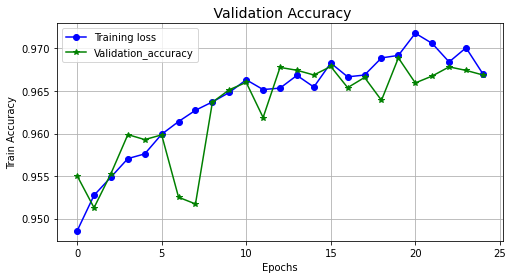

In [48]:
plt.figure(figsize=(8,4))
plt.plot(history_b1.history["binary_accuracy"], label="Training loss", color='blue', marker='o')
plt.plot(history_b1.history["val_binary_accuracy"], label="Validation_accuracy", color='green', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.title(" Validation Accuracy", fontsize=14)
plt.grid('true')
plt.legend()
plt.savefig('B1_Acc.eps', format='eps',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('B1_Acc.pdf', format='pdf',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('B1_Acc.png', format='png',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

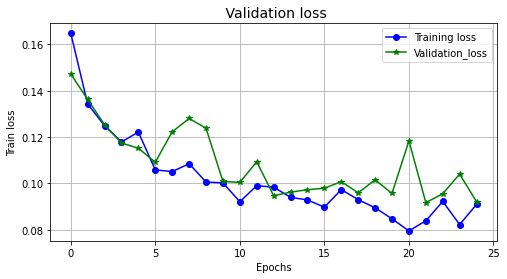

In [49]:
plt.figure(figsize=(8,4))
plt.plot(history_b1.history["loss"], label="Training loss", color='blue', marker='o')
plt.plot(history_b1.history["val_loss"], label="Validation_loss", color='green', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Train loss")
plt.title(" Validation loss", fontsize=14)
plt.grid('true')
plt.legend()
plt.savefig('B1_loss.eps', format='eps',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('B1_loss.pdf', format='pdf',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('B1_loss.png', format='png',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

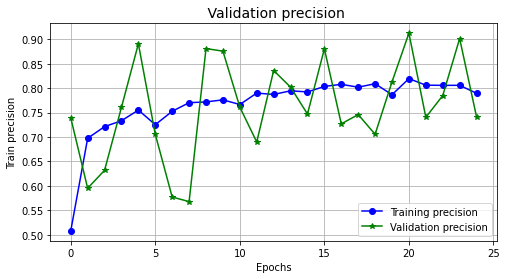

In [50]:
plt.figure(figsize=(8,4))
plt.plot(history_b1.history["precision"], label="Training precision", color='blue', marker='o')
plt.plot(history_b1.history["val_precision"], label="Validation precision", color='green', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Train precision")
plt.title(" Validation precision", fontsize=14)
plt.grid('true')
plt.legend()
plt.savefig('B1_precision.eps', format='eps',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('B1_precision.pdf', format='pdf',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('B1_precision.png', format='png',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

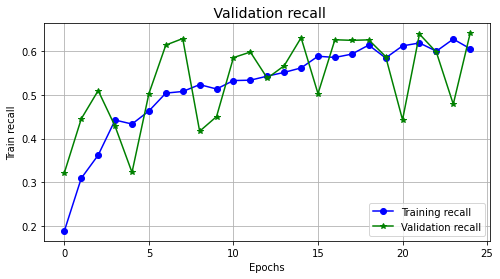

In [51]:
plt.figure(figsize=(8,4))
plt.plot(history_b1.history["recall"], label="Training recall", color='blue', marker='o')
plt.plot(history_b1.history["val_recall"], label="Validation recall", color='green', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Train recall")
plt.title(" Validation recall", fontsize=14)
plt.grid('true')
plt.legend()
plt.savefig('B1_recall.eps', format='eps',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('B1_recall.pdf', format='pdf',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('B1_recall.png', format='png',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

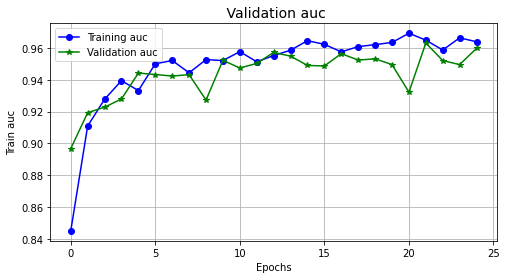

In [52]:
plt.figure(figsize=(8,4))
plt.plot(history_b1.history["auc"], label="Training auc", color='blue', marker='o')
plt.plot(history_b1.history["val_auc"], label="Validation auc", color='green', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Train auc")
plt.title(" Validation auc", fontsize=14)
plt.grid('true')
plt.legend()
plt.savefig('B1_auc.eps', format='eps',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('B1_auc.pdf', format='pdf',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('B1_auc.png', format='png',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

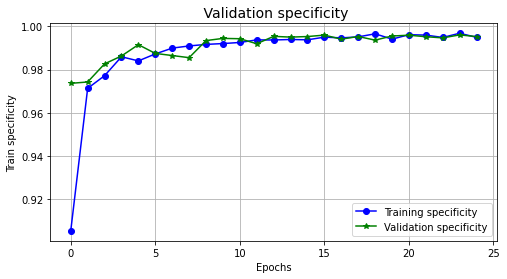

In [53]:
plt.figure(figsize=(8,4))
plt.plot(history_b1.history["specificity_at_sensitivity"], label="Training specificity", color='blue', marker='o')
plt.plot(history_b1.history["val_specificity_at_sensitivity"], label="Validation specificity", color='green', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Train specificity")
plt.title(" Validation specificity", fontsize=14)
plt.grid('true')
plt.legend()
plt.savefig('B1_Specificity.eps', format='eps',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('B1_Specificity.pdf', format='pdf',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('B1_Specificity.png', format='png',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

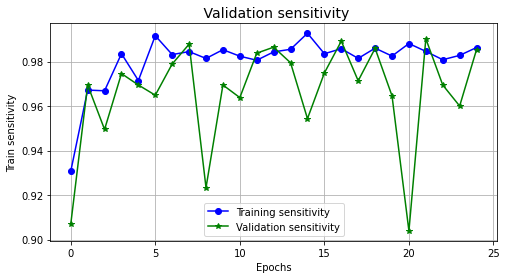

In [54]:
plt.figure(figsize=(8,4))
plt.plot(history_b1.history["sensitivity_at_specificity"], label="Training sensitivity", color='blue', marker='o')
plt.plot(history_b1.history["val_sensitivity_at_specificity"], label="Validation sensitivity", color='green', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Train sensitivity")
plt.title(" Validation sensitivity", fontsize=14)
plt.grid('true')
plt.legend()
plt.savefig('B1_sensitivity.eps', format='eps',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('B1_sensitivity.pdf', format='pdf',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('B1_sensitivity.png', format='png',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In [55]:
h1=branch1.layers[-2]

In [56]:
h1.output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'dropout')>

In [57]:
def predictions(test_df, branch1):    
    test_preds = branch1.predict_generator(test_gen, verbose = 1)
    return test_preds[:test_df.iloc[range(test_df.shape[0])].shape[0]]

In [58]:
len(test_df)

121232

In [59]:
submission_predictions =[]

In [60]:
preds = predictions(test_df, branch1)
submission_predictions.append(preds)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2127/2127 [==============================] - 399s 187ms/step


In [61]:
def build_model():
    print('Building Branch 2 ..')
    branch2 = Sequential()
    branch2.add(xception)
   # model.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
   # model.add(MaxPool2D(pool_size=(2, 2)))
   # model.add(Dropout(0.25))
    
    branch2.add(layers.GlobalAveragePooling2D())
    branch2.add(layers.Dropout(0.3))
    branch2.add(layers.Dense(6, activation='sigmoid'))
    
    branch2.compile(optimizer = keras.optimizers.Adam(), 
                  loss = 'binary_crossentropy',
                  metrics =  ['acc'])
    return branch2

branch2 = build_model()
    
print(f'Model Summary: {branch2.summary()} ')


Building Branch 2 ..
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12294     
Total params: 20,873,774
Trainable params: 20,819,246
Non-trainable params: 54,528
_________________________________________________________________
Model Summary: None 


In [62]:
Early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, 
                                              mode='auto', baseline=None, restore_best_weights=False)

In [63]:
branch2.compile(optimizer = Adam(learning_rate = LR), 
              loss = 'binary_crossentropy', # <- requires balance/ Binary for unbalanced
              metrics = METRICS)

In [64]:
history_b2 = branch2.fit_generator(generator = train_gen,
                    validation_data = val_gen,
                    steps_per_epoch = TRAIN_STEPS,
                    epochs = 25)
                    #callbacks = [Early_stop],
                    #epochs = 30)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
122/122 [==============================] - 162s 1s/step - loss: 0.2209 - binary_accuracy: 0.9629 - precision: 0.7039 - recall: 0.6063 - auc: 0.9529 - specificity_at_sensitivity: 0.9940 - sensitivity_at_specificity: 0.9872 - single_class_crossentropy: 0.2209 - val_loss: 0.0966 - val_binary_accuracy: 0.9680 - val_precision: 0.8303 - val_recall: 0.5494 - val_auc: 0.9511 - val_specificity_at_sensitivity: 0.9950 - val_sensitivity_at_specificity: 0.9573 - val_single_class_crossentropy: 0.0967
Epoch 2/25
122/122 [==============================] - 144s 1s/step - loss: 0.0951 - binary_accuracy: 0.9652 - precision: 0.7923 - recall: 0.5921 - auc: 0.9656 - specificity_at_sensitivity: 0.9952 - sensitivity_at_specificity: 0.9972 - single_class_crossentropy: 0.0951 - val_loss: 0.0961 - val_binary_accuracy: 0.9699 - val_precision: 0.8439 - val_recall: 0.5764 - val_auc: 0.9480 - val_specificity_at_sensitivity: 0.9966 - val_sensitivity_at_specificity: 0.9646 - val_single_class_crossentropy: 0

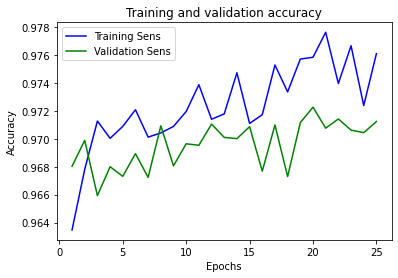

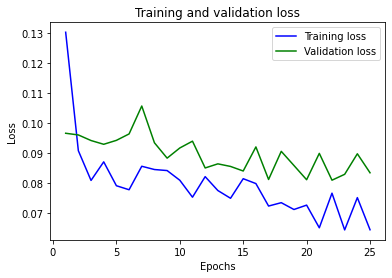

In [65]:
acc = history_b2.history['binary_accuracy']
val_acc = history_b2.history['val_binary_accuracy']
loss = history_b2.history['loss']
val_loss = history_b2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training Sens')
plt.plot(epochs, val_acc, 'g', label='Validation Sens')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [66]:
h2=branch2.layers[-2]

In [67]:
h2.output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'dropout_1')>

In [68]:
#############################################################################
####Setting labels for combined training and testing data
#############################################################################
####################################Training Labels of features###########################
feature_train_labels=pd.DataFrame(train_gen.labels)
print(feature_train_labels)

####################################Test Labels###########################
feature_test_labels=pd.DataFrame(val_gen.labels)
len(feature_test_labels.shape)


        0  1  2  3  4  5
0       0  0  0  0  0  0
1       0  0  0  0  0  0
2       0  0  0  0  0  0
3       0  0  0  0  0  0
4       0  0  0  0  0  0
...    .. .. .. .. .. ..
124993  0  0  0  0  0  0
124994  0  0  0  0  0  0
124995  0  0  0  0  0  0
124996  0  0  0  0  0  0
124997  0  0  0  0  0  0

[124998 rows x 6 columns]


2

In [69]:
from tensorflow.keras.models import Model

In [70]:
from tensorflow.keras.layers import concatenate
###########################
###########################we have taken the features extracted by either 
########branch after the average pooling layer as mentioned in paper###########################
'''
As mentioned in the paper, after the training, features from the last block preceding the ResNet-50’s fully connected layer
were taken from either branch and concatenated. The joint feature vector containing 4096 elements
was subjected to the classification process. As we can check that in output, we are getting right same features 4096.
'''
print('Getting training features and concatenation---------------start')
model1= Model(branch1.input, branch1.layers[-2].output)
model1_features=model1.predict(train_gen)
model1_features=pd.DataFrame(model1_features)
print("Branch1_features", model1_features.shape)

model2= Model(branch2.input, branch2.layers[-2].output)
model2_features=model2.predict(train_gen)
model2_features=pd.DataFrame(model2_features)
print("Branch2_features", model2_features.shape)

Getting training features and concatenation---------------start
Branch1_features (124998, 2048)
Branch2_features (124998, 2048)


In [71]:

####################################Concatenation of features###########################
concatenated_features=pd.concat([model1_features,model2_features], axis=1)
print("Combined_features", concatenated_features.shape)

print('Getting validation features and concatenation---------------start')
model1= Model(branch1.input, branch1.layers[-2].output)
model1_val_features=model1.predict(val_gen)
model1_val_features=pd.DataFrame(model1_val_features)
print("Branch1_val_features", model1_val_features.shape)

model2= Model(branch2.input, branch2.layers[-2].output)
model2_val_features=model2.predict(val_gen)
model2_val_features=pd.DataFrame(model2_val_features)
print("Branch2_val_features", model2_val_features.shape)

Combined_features (124998, 4096)
Getting validation features and concatenation---------------start
Branch1_val_features (10869, 2048)
Branch2_val_features (10869, 2048)


In [72]:
####################################Concatenation of features###########################
concatenated_val_features=pd.concat([model1_val_features,model2_val_features], axis=1)
print("Combined_val_features", concatenated_val_features.shape)
#############################################################################
####Here, we have obtained the fatures from branch1 and branch 2 
#############################################################################

Combined_val_features (10869, 4096)


In [73]:
from sklearn.tree import DecisionTreeClassifier
DT_classification=DecisionTreeClassifier( max_depth=10,min_samples_split=6)
DT_classification.fit(concatenated_features,feature_train_labels)
DT_classification.fit(concatenated_val_features,feature_test_labels)
print("done tarining")

done tarining


In [74]:
####################################################################################
######Performance evaluation of the combined double-branch convolutional neural network (CNN) 
############################based on the ResNet-50 architecture with Random forest#######################
########################################################################################
pred_DT=DT_classification.predict(concatenated_val_features)
print("pred_DT",pred_DT.shape)
from sklearn import metrics
accuracy=metrics.accuracy_score(feature_test_labels,pred_DT.round())
print("Accuracy of combined model with Decision Tree: {0:0.4f}".format(accuracy*100))

from sklearn.metrics import f1_score
f1score=f1_score(pred_DT,feature_test_labels, average='weighted')
print("F1score of combined model with Decision Tree: {0:0.4f}".format( f1score*100))

from sklearn.metrics import recall_score
recall = recall_score(feature_test_labels,pred_DT, average='weighted')
print('Recall score of combined model with Decision Tree: {0:0.4f}'.format(recall*100))

from sklearn.metrics import precision_score
precision = precision_score(pred_DT.round(),feature_test_labels,average='weighted')
print('Precision of combined model with Decision Tree: {0:0.4f}'.format(precision*100))

####################################################################################
####################################################################################

pred_DT (10869, 6)
Accuracy of combined model with Decision Tree: 95.0225
F1score of combined model with Decision Tree: 87.9379
Recall score of combined model with Decision Tree: 80.5886
Precision of combined model with Decision Tree: 81.3551


In [75]:
####################################################################################
######Performance evaluation of the combined double-branch convolutional neural network (CNN) 
############################based on the ResNet-50 architecture with Random forest#######################
########################################################################################

from sklearn.metrics import classification_report
labe=['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
print( classification_report(feature_test_labels,pred_DT, target_names=labe))

                  precision    recall  f1-score   support

             any       0.97      0.84      0.90      1556
        epidural       0.91      0.26      0.41        38
intraparenchymal       0.97      0.84      0.90       518
intraventricular       0.96      0.90      0.93       399
    subarachnoid       0.96      0.70      0.81       500
        subdural       0.93      0.76      0.84       693

       micro avg       0.96      0.81      0.88      3704
       macro avg       0.95      0.72      0.80      3704
    weighted avg       0.96      0.81      0.87      3704
     samples avg       0.12      0.11      0.11      3704



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
####################################################################################
######Performance evaluation of the combined double-branch convolutional neural network (CNN) 
############################based on the ResNet-50 architecture with Random forest#######################
########################################################################################

from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix(feature_test_labels,pred_DT)
print(cm)

[[[ 9274    39]
  [  249  1307]]

 [[10830     1]
  [   28    10]]

 [[10336    15]
  [   82   436]]

 [[10455    15]
  [   40   359]]

 [[10353    16]
  [  151   349]]

 [[10138    38]
  [  169   524]]]


In [77]:
####################################################################################
######Performance evaluation of the combined double-branch convolutional neural network (CNN) 
############################based on the ResNet-50 architecture with Random forest#######################
########################################################################################

first_cat=cm[0]
tn, fp, fn, tp = first_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_1=(tp+tn)/(tp+tn+fp+fn)
print("fpr for any is :{0:0.4f}".format(fpr*100))
print("fnr for any is :  {0:0.4f}".format(fnr*100))
print("TPR for any is :  {0:0.4f}".format(TPR*100))
print("TNR for any is :  {0:0.4f}".format(TNR*100))
print("Accuracy for any is  {0:0.4f}".format(acc_1*100))

second_cat=cm[1]
tn, fp, fn, tp = second_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_2=(tp+tn)/(tp+tn+fp+fn)
print("fpr for epidural is :  ",fpr*100)
print("fnr for epidural is : ",fnr*100)
print("TPR for epidural is : ",TPR*100)
print("TNR for epidural is : ",TNR*100)
print("Accuracy for epidural is : ",acc_2*100)

third_cat=cm[2]
tn, fp, fn, tp = third_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_3=(tp+tn)/(tp+tn+fp+fn)
print("fpr for intraparenchymal is : ",fpr*100)
print("fnr for intraparenchymal is : ",fnr*100)
print("TPR for intraparenchymal is : ",TPR*100)
print("TNR for intraparenchymal is : ",TNR*100)
print("Accuracy for intraparenchymal is ",acc_3*100)

fourth_cat=cm[3]
tn, fp, fn, tp = fourth_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_4=(tp+tn)/(tp+tn+fp+fn)
print("fpr for intraventricular is : ",fpr*100)
print("fnr for intraventricular is :  ",fnr*100)
print("TPR for intraventricular is : ",TPR*100)
print("TNR for intraventricular is : ",TNR*100)
print("Accuracy for intraventricular : is ",acc_4*100)

fifth_cat=cm[4]
tn, fp, fn, tp = fourth_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_5=(tp+tn)/(tp+tn+fp+fn)
print("fpr for subarachnoid is  : ",fpr*100)
print("fnr for subarachnoid is :  ",fnr*100)
print("TPR for subarachnoid is : ",TPR*100)
print("TNR for subarachnoid is : ",TNR*100)
print("Accuracy for subarachnoid is :  ",acc_5*100)

sixth_cat=cm[5]
tn, fp, fn, tp = sixth_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_6=(tp+tn)/(tp+tn+fp+fn)
print("fpr for subdural is : ",fpr*100)
print("fnr for subdural is : ",fnr*100)
print("TPR for subdural is : ",TPR*100)
print("TNR for subdural is :",TNR*100)
print("Accuracy for Subdural is ",acc_6*100)

fpr for any is :0.4188
fnr for any is :  16.0026
TPR for any is :  83.9974
TNR for any is :  99.5812
Accuracy for any is  97.3503
fpr for epidural is :   0.009232757824762256
fnr for epidural is :  73.68421052631578
TPR for epidural is :  26.31578947368421
TNR for epidural is :  99.99076724217524
Accuracy for epidural is :  99.73318612567853
fpr for intraparenchymal is :  0.14491353492416192
fnr for intraparenchymal is :  15.83011583011583
TPR for intraparenchymal is :  84.16988416988417
TNR for intraparenchymal is :  99.85508646507584
Accuracy for intraparenchymal is  99.10755359278683
fpr for intraventricular is :  0.14326647564469913
fnr for intraventricular is :   10.025062656641603
TPR for intraventricular is :  89.97493734335839
TNR for intraventricular is :  99.8567335243553
Accuracy for intraventricular : is  99.4939736866317
fpr for subarachnoid is  :  0.14326647564469913
fnr for subarachnoid is :   10.025062656641603
TPR for subarachnoid is :  89.97493734335839
TNR for subara

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [79]:
Model_pipeline = []
#Model_pipeline.append(LogisticRegression(solver= 'liblinear'))
Model_pipeline.append(DecisionTreeClassifier())
Model_pipeline.append(RandomForestClassifier())
Model_pipeline.append(KNeighborsClassifier())
Model_pipeline.append(GaussianNB())

In [80]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

In [81]:
#model_list = ['DecisionTreeClassifier', 'RandomForestClassifier', 'KNeighborsClassifier','GaussianNB' ]
#acc_list = []
#auc_list = []
#cm_list = []
#for model in Model_pipeline:
 #   model.fit(concatenated_features,feature_train_labels)
  #  y_pred =  model.predict(concatenated_val_features)


In [82]:
#print("pred_Model_Pipline",y_pred.shape)

In [83]:
####################################################################################
######Performance evaluation of the combined double-branch convolutional neural network (CNN) 
############################based on the ResNet-50 architecture with Random forest#######################
########################################################################################
#from sklearn import metrics
#accuracy=metrics.accuracy_score(y_pred,feature_test_labels)
#print("Accuracy of combined model with KNN: {0:0.4f}".format(accuracy*100))

#from sklearn.metrics import f1_score
#f1score=f1_score(y_pred,feature_test_labels, average='weighted')
#print("F1score of combined model with KNN: {0:0.4f}".format( f1score*100))

#from sklearn.metrics import recall_score
#recall = recall_score(feature_test_labels,y_pred, average='weighted')
#print('Recall score of combined model with KNN: {0:0.4f}'.format(recall*100))

#from sklearn.metrics import precision_score
#precision = precision_score(y_pred.round(),feature_test_labels,average='weighted')
#print('Precision of combined model with KNN: {0:0.4f}'.format(precision*100))

####################################################################################
####################################################################################

In [84]:
#from sklearn.metrics import f1_score
#f1score=f1_score(pred_knn,feature_test_labels, average='macro')
#print("F1score of combined model with K: {0:0.4f}".format( f1score*100))

In [85]:
print('ICH Preducation using Custom CNN')
CNN_classifier = Sequential()
CNN_classifier.add(Flatten(input_shape=concatenated_features.shape[1:]))
CNN_classifier.add(Dense(512, activation='relu'))
CNN_classifier.add(Flatten())
CNN_classifier.add(Dense(units=256, activation='relu'))
CNN_classifier.add(Dense(units=128, activation='relu'))
CNN_classifier.add(Dense(units=64, activation='relu'))
CNN_classifier.add(Dropout(0.3))
CNN_classifier.add(Dropout(0.2))
CNN_classifier.add(Flatten())
CNN_classifier.add(Dense(6, activation='softmax'))

CNN_classifier.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

CNN_classifier.summary()

ICH Preducation using Custom CNN
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2097664   
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)  

In [86]:
LR = 0.001

In [87]:
CNN_classifier.compile(optimizer = Adam(learning_rate = LR), 
              loss = 'binary_crossentropy', # <- requires balance/ Binary for unbalanced
              metrics = METRICS)

In [88]:
history=CNN_classifier.fit(concatenated_features, feature_train_labels,
          epochs=10,
          batch_size=32,
validation_data=(concatenated_val_features, feature_test_labels))
#model.save_weights('bottleneck_fc_model.h5')

Epoch 1/10
3907/3907 [==============================] - 32s 8ms/step - loss: 0.2289 - binary_accuracy: 0.9173 - precision: 0.2582 - recall: 0.2367 - auc: 0.7628 - specificity_at_sensitivity: 0.8391 - sensitivity_at_specificity: 0.8219 - single_class_crossentropy: 0.2825 - val_loss: 0.2013 - val_binary_accuracy: 0.9456 - val_precision: 0.8995 - val_recall: 0.0483 - val_auc: 0.7037 - val_specificity_at_sensitivity: 0.6871 - val_sensitivity_at_specificity: 0.7119 - val_single_class_crossentropy: 0.2667
Epoch 2/10
3907/3907 [==============================] - 29s 7ms/step - loss: 0.2054 - binary_accuracy: 0.9188 - precision: 0.1413 - recall: 0.0852 - auc: 0.7021 - specificity_at_sensitivity: 0.7698 - sensitivity_at_specificity: 0.7359 - single_class_crossentropy: 0.2668 - val_loss: 0.2067 - val_binary_accuracy: 0.9439 - val_precision: 0.9800 - val_recall: 0.0132 - val_auc: 0.6931 - val_specificity_at_sensitivity: 0.6971 - val_sensitivity_at_specificity: 0.6830 - val_single_class_crossentrop

In [89]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training Sens')
plt.plot(epochs, val_acc, 'g', label='Validation Sens')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

KeyError: 'categorical_accuracy'

Idea here: make pred on validation, then for each image load the image, the prediciton, and the labels in validation_df 

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history["categorical_accuracy"], label="Training loss", color='blue', marker='o')
plt.plot(history.history["val_categorical_accuracy"], label="Validation_accuracy", color='green', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.title(" Validation Accuracy", fontsize=14)
plt.grid('true')
plt.legend()
plt.savefig('DL_Classifier_Acc.eps', format='eps',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('DL_Classifier_Acc.pdf', format='pdf',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('DL_Classifier_Acc.png', format='png',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train_loss", color='blue', marker='o')
plt.plot(history.history["val_loss"], label="Validation_loss", color='green', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Train loss")
plt.title(" Validation loss", fontsize=14)
plt.grid('true')
plt.legend()
plt.savefig('DL_Classifier_loss.eps', format='eps',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('DL_Classifier_loss.pdf', format='pdf',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('DL_Classifier_loss.png', format='png',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history["precision"], label="Train_precision", color='blue', marker='o')
plt.plot(history.history["val_precision"], label="Validation_precision", color='green', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Train precision")
plt.title(" Validation precision", fontsize=14)
plt.grid('true')
plt.legend()
#plt.savefig('DL_Classifier_loss.eps', format='eps',  bbox_inches='tight', transparent=True, pad_inches=0)
#plt.savefig('DL_Classifier_loss.pdf', format='pdf',  bbox_inches='tight', transparent=True, pad_inches=0)
#plt.savefig('DL_Classifier_loss.png', format='png',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history["recall"], label="Train_recall", color='blue', marker='o')
plt.plot(history.history["val_recall"], label="Validation_recall", color='green', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Train recall")
plt.title(" Validation recall", fontsize=14)
plt.grid('true')
plt.legend()
#plt.savefig('DL_Classifier_loss.eps', format='eps',  bbox_inches='tight', transparent=True, pad_inches=0)
#plt.savefig('DL_Classifier_loss.pdf', format='pdf',  bbox_inches='tight', transparent=True, pad_inches=0)
#plt.savefig('DL_Classifier_loss.png', format='png',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history["specificity_at_sensitivity"], label="Train_specificity", color='blue', marker='o')
plt.plot(history.history["val_specificity_at_sensitivity"], label="Validation_specificity", color='green', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Train specificity")
plt.title(" Validation specificity", fontsize=14)
plt.grid('true')
plt.legend()
#plt.savefig('DL_Classifier_precision.eps', format='eps',  bbox_inches='tight', transparent=True, pad_inches=0)
#plt.savefig('DL_Classifier_precision.pdf', format='pdf',  bbox_inches='tight', transparent=True, pad_inches=0)
#plt.savefig('DL_Classifier_precision.png', format='png',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history["auc"], label="Train_auc", color='blue', marker='o')
plt.plot(history.history["val_auc"], label="Validation_val_auc", color='green', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Train auc")
plt.title(" Validation auc", fontsize=14)
plt.grid('true')
plt.legend()
#plt.savefig('DL_Classifier_precision.eps', format='eps',  bbox_inches='tight', transparent=True, pad_inches=0)
#plt.savefig('DL_Classifier_precision.pdf', format='pdf',  bbox_inches='tight', transparent=True, pad_inches=0)
#plt.savefig('DL_Classifier_precision.png', format='png',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history["sensitivity_at_specificity"], label="Train_sensitivity", color='blue', marker='o')
plt.plot(history.history["val_sensitivity_at_specificity"], label="Validation_vsensitivity", color='green', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Train sensitivity")
plt.title(" Validation sensitivity", fontsize=14)
plt.grid('true')
plt.legend()
#plt.savefig('DL_Classifier_precision.eps', format='eps',  bbox_inches='tight', transparent=True, pad_inches=0)
#plt.savefig('DL_Classifier_precision.pdf', format='pdf',  bbox_inches='tight', transparent=True, pad_inches=0)
#plt.savefig('DL_Classifier_precision.png', format='png',  bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In [ ]:
CNN_classifier.evaluate(concatenated_val_features)

In [ ]:
val_preds = CNN_classifier.predict_generator(concatenated_val_features, verbose = 1)

In [ ]:
val_preds

In [ ]:
y_preds = []
for i in range(len(val_preds)):
    y_preds.append(0)
    for value in val_preds[i]: 
        if value > 0.5: 
            y_preds[i] = 1
            break
            
        
len(y_preds)

In [ ]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_preds)

In [ ]:
y_preds = []
for i in range(len(val_preds)):
    y_preds.append(0)
    for value in val_preds[i]: 
        if value > 0.5: 
            y_preds[i] = 1
            break
            
        
len(y_preds)


In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
print('2*2 Confusion Matrix')
print(confusion_matrix(y_true, y_preds))
cm = confusion_matrix(y_true, y_preds)

In [ ]:
import itertools   
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_labels = ['no hemorrhage', 'has hemorrhage']

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix')